# Project 2, Part 2: Keras with Convolutional Neural Networks

We did pretty good in our last notebook. 87.28% accuracy isn't terrible, but it's 10 points lower than our original MNIST notebook. I think we should be able to do alot better using a **convolutional neural network** (CNN).

CNNs are the standard neural network architecture used for image processing. I'm sure a mathematician would take issue with some of what I'm about to say, but just to give you an intuitive sense of what makes this different from a normal neural network:

Our previous NNs all had an input layer, 1 or more fully connected hidden layers, and an output layer. Our CNN is going have input, 1 or more convolutional layers, 1 or more hidden layers, then the output layer. The convolutional layers 'scan' the image in series of overlapping chunks. Whereas the NN just saw pixel by pixel, a convolutional layer allows our CNN to see larger patterns as part of the 'input' into the hidden layers.

Why's that matter? Isn't 'seeing patterns' what all ML algorithms do? Sure, BUT: CNNs can see patterns in any part of a picture. Let's say we're trying to identify a type of car. The shpae of the headlight would probably factor in to the patterns a NN is looking for. Our basic NN would require that the headlight always be in the exact same location of the picture...which isn't very good when looking at new pictures. CNNs learn what a headlight looks like and can identify it in any part of the photo.

We're going to start with an example of a CNN [given to us by the keras team]('https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py').

In [6]:
# Getting everything set back up
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from numpy import argmax
import pandas as pd


# Load the data from our CSV
training = pd.read_csv('fashion-data/fashion-mnist_train.csv')
test = pd.read_csv('fashion-data/fashion-mnist_test.csv')

# Make a new dataframe using only the labels
training_labels = training.label
training_features = training.drop('label', axis=1)
test_labels = test.label
test_features = test.drop('label', axis=1)

# One hot lables
training_labels_oh = keras.utils.to_categorical(training_labels, num_classes=10)
test_labels_oh = keras.utils.to_categorical(test_labels, num_classes=10)

# For pretty printing
label_dict = {
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

## Weird-o shapes

We're going to have to reshape our data for the CNNs. Our basic NN just scanned the data pixel by pixel. Our CNN is going to be scanning over the picture, so we need to feed it a picture shaped graph.

"Picture shaped graph" is misleading in this context. We'd expect a 2D graph, but in the code below you'll actually notice a 4D graph. The dimensions correspond to number of intances (the overall number of training and testing examples), height, width, and channels.

"Channels" means number of color channels. We have a single channel that goes from 0 to 255 (white to black) and therefore use a "1". Color pictures are likely going to use a 3 for RGB. You can imagine a satellite image that uses infrared using 4 or more channels. 

In [7]:
# Reshape our features into 28x28 pictures
training_features_shaped = training_features.values.reshape(training_features.shape[0], 28, 28, 1)
test_features_shaped = test_features.values.reshape(test_features.shape[0], 28, 28, 1)

In [8]:
# Checking our shapes
print('training_features_shaped shape:', training_features_shaped.shape)
print('test_features_shaped shape:', test_features_shaped.shape)

training_features_shaped shape: (60000, 28, 28, 1)
test_features_shaped shape: (10000, 28, 28, 1)


## Breaking down the example

Let's look at our new layer types

- **Conv2D:**
    - **filters:** Ok, you won't literally see the word 'filters' in the code. This is the first number passed to the Conv2D class. It's the '32' in the first layer of the model below. Think of these as the differnt filters applied to an image so that we can pick out general feautes. For example, we might end up with filters that bring out the vertical, horizontal, and diagonal lines. The filters in successive layers get more detailed. A CNN meant to identify faces will look for simple lines in the early convolutional layers, but might be looking for eyebrows, chins, or ears in the 2nd or 3rd layer.
    - **kernel_size:** Remember when we said "The convolutional layers 'scan' the image in series of overlapping chunks"? This parameter is the size of the chunk that is scanned. So in this example we are scanning 3x3 pieces of the 28x28 images.
    - **strides:** Stride is how far the convolution moves from one 'chunk' to the next. You have to define this variable with a tuple of the same dimension as your layer. Our 2D layer is going to need a tuple of 2 numbers. Think of the first number as the rightward scanning movement and the 2nd as the downward. This parameter isn't explicitly called out in the code below. We're just inheriting the default value of (1, 1). So each of our 28x28 pictures is going to be scanned in 3x3 blocks and the scanner can be thought of as moving from left to right, top to bottom, moving over 1 square at a time.
        - Example: Imagine our 28x28 grid. We're starting in a 3x3 box at the top left. We then move our 3x3 box over 1 column to the right. The 2 right most columns in the first box are now the 2 left most columns.
    - **activation:** Remember when we talked about how enough incoming connections activating resulted in a node "lighting up"? Well we need an equation that determines the 'lit' vs 'not lit' state. We call this the activation function.
        - **RELU:** You're typically going to see either Sigmoid or RELU activation function. All you really need to know for now is that RELU is faster and more performant.
    - **input_shape:** The shape of the picutes that will be fed into this layer. Note that this does NOT include the number of features dimension from the "Weird-o shapes" section above, but the others are the same. The convolutional layer needs to know the size of the picture and the channels, but will just be getting one picture at a time. It doesn't care about the overall number of pictures.

- **MaxPooling2D:** CNN are computationally expensive. You can focus the data, speed up your training, and use less resources by shrinking your picture in a pooling layer. We're specifically using a **max** pooling layer. Imagine we're 'scanning' our picutre again. We start in a 2x2 square in the top left of the picutre. We take whatever number is largest in that 2x2 square and write that as the number in the top left corner of our new picture. This allows us to shrink the image while maintaining the spatial ratios.
    - **pool_size:** The size of the square we're scanning with. We're using 2x2 in our first pooling layer. Every 2x2 square will be reduced to a single square with a value equal to the largest number in the 2x2 square.

- **Dropout:** This layer isn't CNN specific. It's a common technique used in ML to help prevent overfitting. The number in this layer is the percentage of inputs that will randomly be set to zero in a given batch. If 25% of the data is randomly dropped, you're going to have a hard time overfitting your data.

- **Flatten:** What's our output layer look like? It's a 1D softmax. But we're feeding 3D, 28x28x1 images into the CNN layers. This layer just flattens our 3D picture into 1D for processing by the final, normal, fully connected layers. Note that this also includes a Dense layer.

In [9]:
model = Sequential()
# This creates a 32 filter, 2D convolutional layer.
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(training_features_shaped, training_labels_oh,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(test_features_shaped, test_labels_oh))
score = model.evaluate(test_features_shaped, test_labels_oh, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/step - loss: 2.7996 - acc: 0.6960 - val_loss: 0.3773 - val_acc: 0.8604
Epoch 2/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.4040 - acc: 0.8575 - val_loss: 0.3151 - val_acc: 0.8871
Epoch 3/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.3466 - acc: 0.8778 - val_loss: 0.3001 - val_acc: 0.8895
Epoch 4/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.3169 - acc: 0.8872 - val_loss: 0.2687 - val_acc: 0.9024
Epoch 5/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.2924 - acc: 0.8950 - val_loss: 0.2516 - val_acc: 0.9099
Epoch 6/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.2777 - acc: 0.9013 - val_loss: 0.2376 - val_acc: 0.9110
Epoch 7/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.2625 - acc: 0.9046 - val_loss: 0.2499 - val_acc

Index: 1001
Label_Number: 2
Label: Pullover
Prediction_Number: 2
Prediction_Number: Pullover


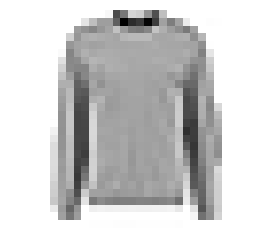

In [10]:
# Same print function as other notebooks, with modifications to account for updated input shapes.
def print_prediction(model, index, test_features, test_features_shaped, test_labels, one_hot_test_labels):

    our_clothing = test_features.iloc[index]
    our_clothing_shaped_for_graphing = our_clothing.values.reshape(28, 28)
    our_clothing_shaped_for_prediction = our_clothing.values.reshape(1, -1)

    print(f'Index: {index}')
    label_num = test_labels.iloc[index]
    print(f'Label_Number: {label_num}')
    print(f'Label: {label_dict[label_num]}')
    # Make the prediction, then convert from one hot encode.
    predict_num = argmax(model.predict(test_features_shaped)[index])
    print(f'Prediction_Number: {predict_num}')
    print(f'Prediction_Number: {label_dict[predict_num]}')
    plt.imshow(our_clothing_shaped_for_graphing, cmap=matplotlib.cm.binary)
    plt.axis("off")
    plt.show()
    
print_prediction(model, 1001, test_features, test_features_shaped, test_labels, test_labels_oh)

In [11]:
model.save('model3.h5')

## More of the same

Other than the pieces of CNNs that I exaplined earlier, everything in those results should seem pretty straight forward by now.

### But can we imporve?!

Let's see:

**Note:** I'm going to leave all of the training epcohs in. Scroll down for more commentary

In [69]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model2.fit(training_features_shaped, training_labels_oh,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(test_features_shaped, test_labels_oh))
score2 = model2.evaluate(test_features_shaped, test_labels_oh, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 10s 159us/step - loss: 5.2887 - acc: 0.5784 - val_loss: 0.4721 - val_acc: 0.8481
Epoch 2/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.4019 - acc: 0.8607 - val_loss: 0.3418 - val_acc: 0.8823
Epoch 3/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.3339 - acc: 0.8822 - val_loss: 0.3167 - val_acc: 0.8940
Epoch 4/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2990 - acc: 0.8946 - val_loss: 0.2958 - val_acc: 0.8944
Epoch 5/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2689 - acc: 0.9054 - val_loss: 0.3016 - val_acc: 0.8975
Epoch 6/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2484 - acc: 0.9132 - val_loss: 0.2778 - val_acc: 0.9075
Epoch 7/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2280 - acc: 0.9214 - val_loss: 0

In [70]:
model2.save('model4.h5')

### A brief, important side bar: Why so bouncy?

This is the first large training I've left in any of my notebooks. You may have noticed that:

1. We didn't just keep improving forever.
2. Rather than just hitting a best value and staying, we bounced around our top value.

Think back to the Optimizer explanation from the last notebook. We feed a batches worth of values in then use back propagation to tweak the weights in our network. Our network will likely never be perfect, so it's going to just bounce around the best weights, and therefore bounce around the best accuracy.

This brings us to our next important ML term: **Learning rate**.

If we want, we're able to tweak the learning rate of our optimizer. This basically represents how large our wieght tweaking jumps are. 
- A large learning rate will reach optimal weights more quickly but risks severe overshooting and the possibility of never actually finding the best wieghts. 
- A small learning rate will potentially bring you to a more exact answer, but risks longer traning times and getting 'stuck' in a small valley.
    - Picture a jagged graph that is overall shaped like a 'U'. This graph represents your optimal weights. It's possible to get stuck inside of small valley on either end of the 'U' without ever getting to the true bottom. A large learning rate will 'see' far enough outisde of the small valley to not get stuck.
    
You can also typically set a **decay** for your learning rate. This represents the amount your learning rate will lower over time. Think of it this way: You can set your learning rate to a higher number so it quickly finds the major valley, but it will lower with every epoch so that it settles into the valley with a lower learning rate over time.
    
#### What do I do with this?

If you're feeling really spunky, you can go play with the optimizer's settings. [Here's](https://keras.io/optimizers/) the docs on optimizers. And here's how you would update the learning rate and decay for the optimizer that we used in our training:

```python
# The listed numbers are the default
ada = keras.optimizers.Adadelta(lr=1.0 , decay=0.0)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=ada)
```

### Back to our scheduled program:
#### Turns out the Keras team knows what they're doing....

You'll notice my final CNN is almost exactly the same as the keras provided example.

I spent a few hours toying with different CNN architectures. Most of my results had roughly the same accuracy with slower training speeds. Many of scenarios I tried resulted in severe overfitting. I was getting a lot of 99.6% accuracy on the training data and close to 88% on the validation and test data. Apparently those dropout layers are doing some serious lifting!

Ditching the pooling layer helped. Remember, those are really for training speed and reducing computation costs. There are obviously uses, but for our small, simple dataset it was just holding us back. This seemed to add ~0.5% accuracy.

I increased the epochs from 10 to 100. This also seemed to add ~0.5% accuracy. But we were bouncing around 92% for almost all of the training. We first hit 92% at epoch 21. Loss did much better with more epochs and didn't seem to start bottoming out until around epoch 60-75. I don't think any more than 100 epochs would be helpful.

### How'd we do overall?

Let's check our progress across all the NNs form both notebooks.

As a reminder, here's a few kaggle entries:
1. [92.72%](https://www.kaggle.com/bugraokcu/cnn-with-keras)
2. [91.76%](https://www.kaggle.com/pavansanagapati/fashion-mnist-cnn-model-with-tensorflow-keras)
3. [76.80%](https://www.kaggle.com/kmader/capsulenet-on-fashion-mnist)

|Run Num |Training Loss|Training Accuracy|Testing Loss|Testing Accuracy|
|--------|------------ |-----------------|------------|----------------|
|1       |12.89        |19.97%           |12.9        |19.92%          |
|2       |0.14         |94.93%           |0.57        |87.28%          |
|3       |0.23         |91.83%           |0.25        |91.33%          |
|4       |0.07         |98.21%           |0.51        |92.53%          |

Given our ranking among top Kaggle performers and my failed architecture experiments, I'm not convinced we could do much better. I think we'd need more data. With more time I'd like to run transformations on our data to artificially increase the amount of training data (doing things like rotating and warping pictures).

We'll get to that later. I'm on to new projects for now!